# Introduction to this notebook
This is the third in a series of notebooks on German temperature data from 1990 to 2021.

* The [first notebook](https://github.com/ritik8801/Time-Series-Forecasting-of-German-Climate-Data-using-Python/blob/main/Read%20%26%20Transform%20Data/read-and-transform-data.ipynb) described how the data were downloaded and transformed in a suitable format for further analysis.
* The [second notebook](https://github.com/ritik8801/Time-Series-Forecasting-of-German-Climate-Data-using-Python/blob/main/Clean%20%26%20Select%20Data/clean-and-select-data.ipynb) cleaned up the data and filtered data from 55 of the originally 513 weather stations. Data were also filtered to the time period 1996 to 2021, because before this period, the data turned out to be significantly more sparse.

The notebook at hand

* imputes some missing data
* calculates the mean temperature of the 55 weather stations to retrieve one single time series
* resamples the frequency from 10 minutes to hourly
* decomposes the time series to
  * trend
  * daily seasonality
  * yearly seasonality
  * and the residuals


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/german-temperature-data-1990-2021/zehn_min_tu_Beschreibung_Stationen.txt
/kaggle/input/german-temperature-data-1990-2021/DESCRIPTION_obsgermany_climate_10min_tu_historical_en.pdf
/kaggle/input/german-temperature-data-1990-2021/german_temperature_data_1996_2021_from_selected_weather_stations/german_temperature_data_1996_2021_from_selected_weather_stations.csv
/kaggle/input/german-temperature-data-1990-2021/german_temperature_data_1990_2021/german_temperature_data_1990_2021.csv


In [3]:
input_file = "/kaggle/input/german-temperature-data-1990-2021/" \
    + "german_temperature_data_1996_2021_from_selected_weather_stations/" \
    + "german_temperature_data_1996_2021_from_selected_weather_stations.csv"
df = pd.read_csv(input_file, index_col="MESS_DATUM")
df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S")

In [4]:
df.head()

,164,183,198,222,298,427,591,596,656,691,...,4501,4625,4642,4745,5142,5397,5440,5546,5629,5705
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1996-01-01 00:00:00,-10.8,-4.7,-6.6,-2.6,NaN,-9.7,-13.0,-10.5,-5.6,-7.6,...,-3.0,-13.1,-10.3,-9.6,-10.8,-5.6,-5.0,-10.2,-8.1,-1.7
1996-01-01 00:10:00,-10.9,-4.8,-6.6,-2.7,NaN,-9.7,-13.0,-10.7,-5.8,-7.5,...,-2.5,-13.1,-10.2,-9.6,-10.9,-5.6,-4.9,-10.2,-8.1,-1.8
1996-01-01 00:20:00,-11.0,-4.7,-6.6,-2.8,NaN,-9.7,-12.9,-10.7,-5.8,-7.6,...,-1.9,-13.0,-10.1,-9.6,-10.9,-5.6,-4.8,-10.2,-8.0,-1.9
1996-01-01 00:30:00,-11.0,-4.6,-6.6,-2.8,NaN,-9.6,-13.0,-10.7,-5.8,-7.6,...,-1.5,-12.9,-10.0,-9.7,-11.0,-5.6,-4.6,-10.2,-8.0,-1.9
1996-01-01 00:40:00,-10.9,-4.4,-6.6,-2.9,NaN,-9.6,-13.0,-10.7,-5.7,-7.6,...,-1.1,-12.8,-10.0,-9.8,-11.4,-5.6,-4.6,-10.2,-8.0,-2.0


In [5]:
df.shape

(1367568, 55)

In [6]:
df.describe()

,164,183,198,222,298,427,591,596,656,691,...,4501,4625,4642,4745,5142,5397,5440,5546,5629,5705
count,1.361749e+06,1.358536e+06,1.356032e+06,1.350515e+06,1.349487e+06,1.365967e+06,1.356134e+06,1.353039e+06,1.354936e+06,1.360255e+06,...,1.356096e+06,1.354393e+06,1.355988e+06,1.364095e+06,1.356824e+06,1.358567e+06,1.362092e+06,1.349691e+06,1.358852e+06,1.360609e+06
mean,9.471091e+00,9.099188e+00,9.867099e+00,8.971865e+00,9.072885e+00,9.957659e+00,9.621270e+00,9.402745e+00,6.951596e+00,9.966560e+00,...,5.621306e+00,9.580115e+00,9.774881e+00,9.466016e+00,9.345807e+00,8.738272e+00,9.529414e+00,9.227648e+00,1.000377e+01,1.025718e+01
std,8.209431e+00,6.629701e+00,8.198274e+00,8.224565e+00,7.340863e+00,8.405636e+00,7.682874e+00,6.931232e+00,7.603299e+00,7.385830e+00,...,7.739982e+00,7.618207e+00,8.100634e+00,7.646919e+00,7.808170e+00,8.440806e+00,8.428579e+00,8.236988e+00,8.366935e+00,8.233181e+00
min,-2.200000e+01,-1.620000e+01,-2.050000e+01,-2.240000e+01,-2.340000e+01,-2.170000e+01,-2.290000e+01,-1.810000e+01,-2.140000e+01,-2.010000e+01,...,-2.090000e+01,-2.070000e+01,-2.370000e+01,-2.280000e+01,-2.870000e+01,-2.330000e+01,-2.150000e+01,-2.100000e+01,-2.130000e+01,-2.000000e+01
25%,3.300000e+00,3.900000e+00,3.800000e+00,2.900000e+00,3.600000e+00,3.700000e+00,4.000000e+00,4.200000e+00,1.100000e+00,4.700000e+00,...,-2.000000e-01,3.900000e+00,3.800000e+00,3.900000e+00,3.500000e+00,2.200000e+00,3.100000e+00,3.100000e+00,3.700000e+00,4.000000e+00
50%,9.300000e+00,8.800000e+00,9.700000e+00,8.900000e+00,8.900000e+00,9.800000e+00,9.500000e+00,9.300000e+00,6.800000e+00,9.800000e+00,...,5.500000e+00,9.400000e+00,9.600000e+00,9.300000e+00,9.200000e+00,8.500000e+00,9.300000e+00,9.200000e+00,9.800000e+00,1.000000e+01
75%,1.540000e+01,1.460000e+01,1.570000e+01,1.480000e+01,1.460000e+01,1.610000e+01,1.510000e+01,1.470000e+01,1.240000e+01,1.520000e+01,...,1.130000e+01,1.510000e+01,1.550000e+01,1.480000e+01,1.530000e+01,1.480000e+01,1.550000e+01,1.520000e+01,1.600000e+01,1.610000e+01
max,3.730000e+01,4.440000e+01,3.860000e+01,3.670000e+01,3.510000e+01,3.820000e+01,4.560000e+01,3.430000e+01,3.500000e+01,3.730000e+01,...,3.160000e+01,3.590000e+01,3.860000e+01,3.710000e+01,3.670000e+01,3.690000e+01,3.780000e+01,3.710000e+01,3.770000e+01,3.930000e+01


In [7]:
df.index.freq="10min"

In [8]:
df.index

DatetimeIndex(['1996-01-01 00:00:00', '1996-01-01 00:10:00',
               '1996-01-01 00:20:00', '1996-01-01 00:30:00',
               '1996-01-01 00:40:00', '1996-01-01 00:50:00',
               '1996-01-01 01:00:00', '1996-01-01 01:10:00',
               '1996-01-01 01:20:00', '1996-01-01 01:30:00',
               ...
               '2021-12-31 22:20:00', '2021-12-31 22:30:00',
               '2021-12-31 22:40:00', '2021-12-31 22:50:00',
               '2021-12-31 23:00:00', '2021-12-31 23:10:00',
               '2021-12-31 23:20:00', '2021-12-31 23:30:00',
               '2021-12-31 23:40:00', '2021-12-31 23:50:00'],
              dtype='datetime64[ns]', name='MESS_DATUM', length=1367568, freq='10T')

# Imputation of missing values
For decomposition methods like STL or MSTL, the time series may not contain any missing values.

We impute them by using the weekly mean of the respective weather station.

In [9]:
result = {}
for col in df.columns:
    n_missing = df[col].isnull().sum()
    result[col] = n_missing/len(df[col]) * 100

missing_values = pd.DataFrame(result.values(), index=result.keys(), columns=["Missing values"])
missing_values.sort_values(by="Missing values", ascending=False, inplace=True)

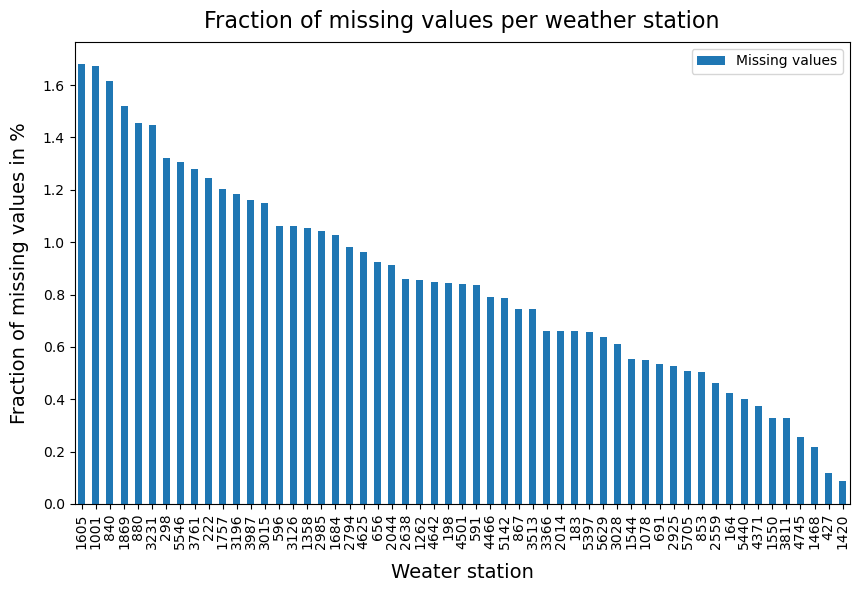

In [10]:
missing_values.plot(kind="bar", figsize=(10, 6))
plt.title("Fraction of missing values per weather station", fontdict={"size" : 16}, pad=10)
plt.ylabel("Fraction of missing values in %", fontsize=14, labelpad=10)
plt.xlabel("Weater station", fontsize=14, labelpad=10);

In [11]:
df_orig = df.copy()

# Calculate the weakly mean for each weather station.
weekly_means = df.groupby(df.index.isocalendar().week).mean()

# Impute the values.
for week in range(1, 54):
    week_idx = df.loc[df.index.isocalendar().week == week].index
    for col in df.columns:
        df.loc[week_idx, col] = df.loc[week_idx, col].fillna(weekly_means.loc[week, col])

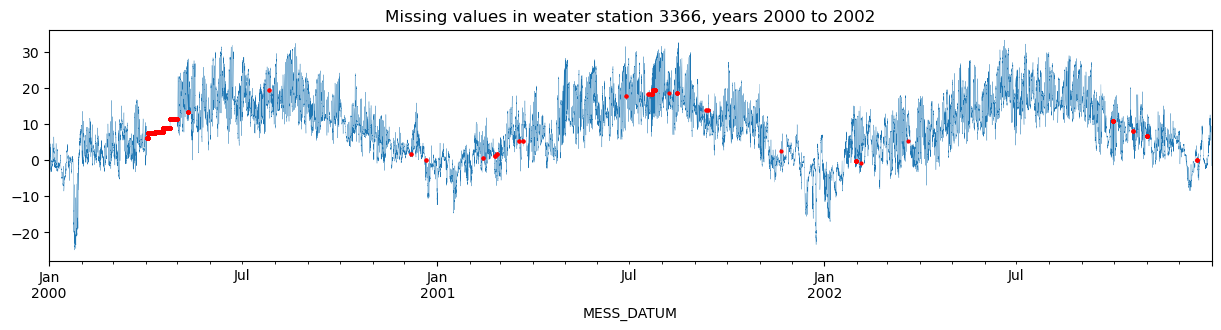

In [12]:
# Here is an example how this works even for larger gaps.
start_year, end_year, ws = "2000", "2002", "3366"

imputed = df.loc[start_year:end_year, ws][df_orig.loc[start_year:end_year, ws].isnull()]
ax = df.loc[start_year:end_year, ws].plot(linestyle="-", linewidth=0.2, figsize=[15, 3])
imputed.plot(ax=ax, linestyle="", marker=".", ms=4, legend=None, color="r")
plt.title("Missing values in weater station " \
          + str(ws) + ", years " + start_year + " to " + end_year);

In [13]:
del(df_orig, imputed)

# Manual decomposition of the time series
"Out of the box" decomposition methods like

* statsmodels.tsa.seasonal.MSTL
* statsmodels.tsa.seasonal.STL
* statsmodels.tsa.seasonal.seasonal_decompose

did not a convicing job in my trials. I noticed the following problems:

* MSTL has a very high computational cost, especially with large amounts of data points. When I want to capture the daily temperature pattern, I need approximately 24 * 365 * (2022-1995) = 236520 datapoints. Moreover, this pattern is difficult to spot, because it varies during the year (more spread in the summer), and MSTL is not able to recognize this adequately.
* STL also has a high computational cost. It captures only one seasonal pattern.
* The moving average based approach of seasonal_decompose works efficient, but captures only one seasonal pattern and has some other drawbacks like producing missing values and lags.

For these (and some more minor) reasons, I tried to realize the decomposition "by hand". The idea follows the principles of MSTL:

* detrend the time series using LOWESS
* then first capture the daily seasonality
* then capture the yearly seasonality
* finally calculate the residuals.

The decomposition will be executed on the mean of all weather stations.

Moreover, the data will be resampled from 10min frequency to hourly frequency.

# Take the mean of all weather stations

In [14]:
all_stations_mean = df.mean(axis=1).to_frame()
all_stations_mean.columns = ["temperature"]
all_stations_mean.head()

,temperature
MESS_DATUM,
1996-01-01 00:00:00,-5.964595
1996-01-01 00:10:00,-5.928231
1996-01-01 00:20:00,-5.900958
1996-01-01 00:30:00,-5.882776
1996-01-01 00:40:00,-5.877322


# Extract the trend

In [15]:
# As LOWESS is quite slow with a high amount of datapoints,
# we let it run on the daily mean values instead of the
# 10 minute frequency values. Later, we have to stretch out
# the trend again, because we want to capture the daily patterns.

daily = all_stations_mean.resample("D").mean()
y = daily["temperature"]
x = np.arange(0, len(y))

In [16]:
# We choose the fraction, so that we do not see the yearly seasonality any more,
# but still see some yearly fluctuations.

res = lowess(
    endog=y,
    exog=x,
    frac=0.12,
    it=3,
)
daily["lowess"] = res[:, 1]

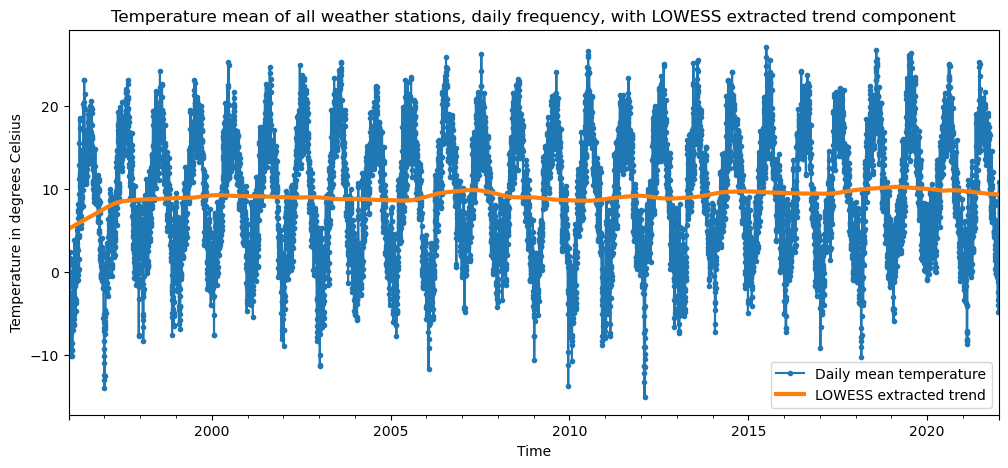

In [17]:
fig, ax = plt.subplots(figsize=[12, 5])
daily.plot(y="temperature", marker=".", ax=ax, label="Daily mean temperature")
daily.plot(y="lowess", ax=ax, linewidth=3, label="LOWESS extracted trend")
ax.set_title("Temperature mean of all weather stations, daily frequency, " \
             + "with LOWESS extracted trend component")
ax.set_ylabel("Temperature in degrees Celsius")
ax.set_xlabel("Time");

In [18]:
print(all_stations_mean.shape, daily.shape)
print(str(all_stations_mean.shape[0] / daily.shape[0]))

(1367568, 1) (9497, 2)
144.0


In [19]:
# Stretch out the LOWESS data to 10min frequency by doing the following steps:
# - duplicate the data 144 times
# - sort by index
# - impute the index of the original 10min index
# - add the data as new column to the original dataframe.

stretched_lowess = pd.concat([daily]*144).sort_index()
stretched_lowess.drop("temperature", axis=1, inplace=True)
stretched_lowess.index = all_stations_mean.index
all_stations_mean["lowess"] = stretched_lowess["lowess"]
del(stretched_lowess)

In [20]:
# Create the detrended data.

all_stations_mean["detrended"] = all_stations_mean["temperature"] - all_stations_mean["lowess"]

In [21]:
all_stations_mean.head()

,temperature,lowess,detrended
MESS_DATUM,,,
1996-01-01 00:00:00,-5.964595,5.203269,-11.167864
1996-01-01 00:10:00,-5.928231,5.203269,-11.131500
1996-01-01 00:20:00,-5.900958,5.203269,-11.104227
1996-01-01 00:30:00,-5.882776,5.203269,-11.086045
1996-01-01 00:40:00,-5.877322,5.203269,-11.080591


In [22]:
all_stations_mean.describe()

,temperature,lowess,detrended
count,1.367568e+06,1.367568e+06,1.367568e+06
mean,9.092107e+00,9.132464e+00,-4.035680e-02
std,7.723052e+00,7.280642e-01,7.689005e+00
min,-1.858364e+01,5.203269e+00,-2.776288e+01
25%,3.172727e+00,8.834205e+00,-5.995805e+00
50%,8.925455e+00,9.115051e+00,-2.221089e-01
75%,1.483052e+01,9.597237e+00,5.697369e+00
max,3.418909e+01,1.028142e+01,2.457348e+01


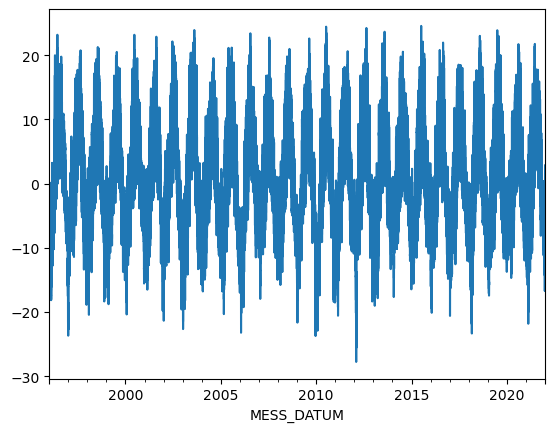

In [23]:
all_stations_mean["detrended"].plot();

# Extract the daily seasonality

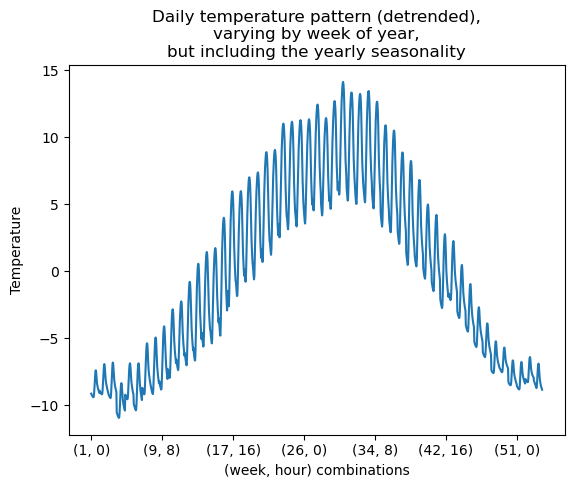

In [24]:
# First, we group the data by week and hour.
# This gives us mean values for every hour,
# but differentiated by the yearly seasonality.

week = all_stations_mean.index.isocalendar().week
hour = all_stations_mean.index.hour
weekly_and_hourly_mean = all_stations_mean["detrended"].groupby([week, hour]).mean()

weekly_and_hourly_mean.plot()
plt.title("Daily temperature pattern (detrended),\nvarying by week of year,\n" \
          + "but including the yearly seasonality")
plt.xlabel("(week, hour) combinations")
plt.ylabel("Temperature");

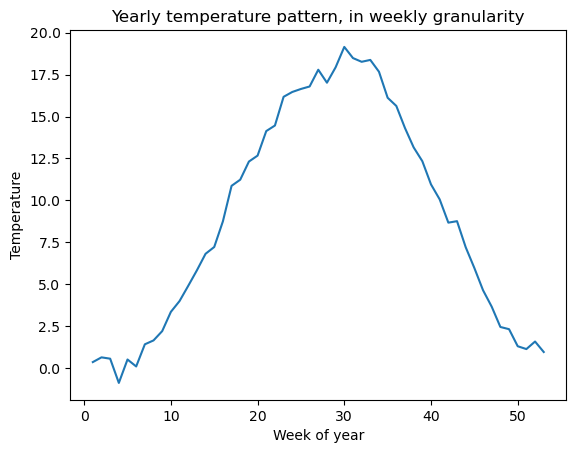

In [25]:
all_stations_weekly_mean = all_stations_mean["temperature"].groupby(week).mean()
weekly_lowess_mean = daily.groupby(week).mean()

all_stations_weekly_mean.plot()
plt.title("Yearly temperature pattern, in weekly granularity")
plt.xlabel("Week of year")
plt.ylabel("Temperature");

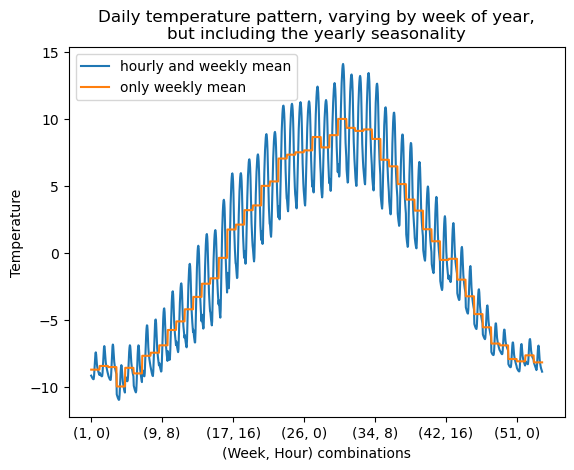

In [26]:
# Now we "duplicate" the weekly means 24 times,
# so that the shape matches the data grouped by week and hour.
# Afterwards, we use the index of the hourly/weekly means.

# To center the data around zero, we subtract the weekly mean from the lowess fit.
week = daily.index.isocalendar().week
weekly_lowess_mean = daily.groupby(week).mean()
weekly_mean = all_stations_weekly_mean - weekly_lowess_mean["lowess"]

# We "stretch out" these data to 24 hours.
multiplied_weekly_means = pd.concat([weekly_mean]*24).sort_index()
multiplied_weekly_means.index = weekly_and_hourly_mean.index

# Compare the two curves.
weekly_and_hourly_mean.plot(label="hourly and weekly mean")
multiplied_weekly_means.plot(label="only weekly mean")

plt.legend()
plt.title("Daily temperature pattern, varying by week of year,\n" \
          + "but including the yearly seasonality")
plt.xlabel("(Week, Hour) combinations")
plt.ylabel("Temperature");

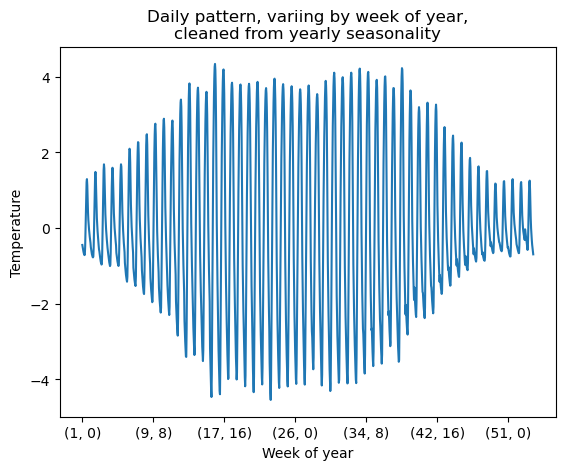

In [27]:
# We finally subtract the weekly means to receive the cleaned daily pattern.

weekly_and_hourly_mean_cleaned = weekly_and_hourly_mean - multiplied_weekly_means
weekly_and_hourly_mean_cleaned.plot()

plt.title("Daily pattern, variing by week of year,\ncleaned from yearly seasonality")
plt.xlabel("Week of year")
plt.ylabel("Temperature");

# What have we reached so far?
* We detrended the data.
* We found a daily pattern depending on the point in time of the year (represented by the "week of year").
* We are now ready to subtract this daily seasonality from the detrended data and then go on to find the yearly seasonality.

# Subtract the daily fluctuations

In [28]:
# We prepare the target dataframe for merging in the daily pattern.
# We create a "week-hour" columns that can serve as join column with the daily pattern.

target_df = all_stations_mean["temperature"].to_frame().copy()
target_df = target_df.resample("1H").mean()
target_df["week"] = target_df.index.isocalendar().week
target_df["hour"] = target_df.index.hour
target_df["week-hour"] = list(zip(target_df["week"], target_df["hour"]))
target_df.drop(["week", "hour"], axis=1, inplace=True)
target_df.head(10)

,temperature,week-hour
MESS_DATUM,,
1996-01-01 00:00:00,-5.907625,"(1, 0)"
1996-01-01 01:00:00,-5.906467,"(1, 1)"
1996-01-01 02:00:00,-5.984898,"(1, 2)"
1996-01-01 03:00:00,-6.015667,"(1, 3)"
1996-01-01 04:00:00,-6.106716,"(1, 4)"
1996-01-01 05:00:00,-5.873243,"(1, 5)"
1996-01-01 06:00:00,-5.857019,"(1, 6)"
1996-01-01 07:00:00,-5.724292,"(1, 7)"
1996-01-01 08:00:00,-5.475802,"(1, 8)"


In [29]:
# We prepore the daily pattern for merging by creating the same "week-hour" column.

daily_pattern = weekly_and_hourly_mean_cleaned.reset_index()
daily_pattern.columns = ["week", "hour", "daily_fluctuation"]
daily_pattern["week-hour"] = list(zip(daily_pattern["week"], daily_pattern["hour"]))
daily_pattern.drop(["week", "hour"], axis=1, inplace=True)
daily_pattern.head(10)

,daily_fluctuation,week-hour
0,-0.446089,"(1, 0)"
1,-0.505196,"(1, 1)"
2,-0.559364,"(1, 2)"
3,-0.612064,"(1, 3)"
4,-0.659184,"(1, 4)"
5,-0.689745,"(1, 5)"
6,-0.713751,"(1, 6)"
7,-0.704720,"(1, 7)"
8,-0.492715,"(1, 8)"
9,-0.031580,"(1, 9)"


In [30]:
merged = pd.merge(target_df, daily_pattern, left_on="week-hour", right_on="week-hour", how="left")
merged.drop("week-hour", axis=1, inplace=True)
merged.index = target_df.index
target_df = merged
del(merged)

In [31]:
target_df["temperature_without_daily_fluctuation"] = \
        target_df["temperature"] - target_df["daily_fluctuation"]
target_df.head(10)

,temperature,daily_fluctuation,temperature_without_daily_fluctuation
MESS_DATUM,,,
1996-01-01 00:00:00,-5.907625,-0.446089,-5.461536
1996-01-01 01:00:00,-5.906467,-0.505196,-5.401271
1996-01-01 02:00:00,-5.984898,-0.559364,-5.425534
1996-01-01 03:00:00,-6.015667,-0.612064,-5.403603
1996-01-01 04:00:00,-6.106716,-0.659184,-5.447532
1996-01-01 05:00:00,-5.873243,-0.689745,-5.183498
1996-01-01 06:00:00,-5.857019,-0.713751,-5.143268
1996-01-01 07:00:00,-5.724292,-0.704720,-5.019572
1996-01-01 08:00:00,-5.475802,-0.492715,-4.983087


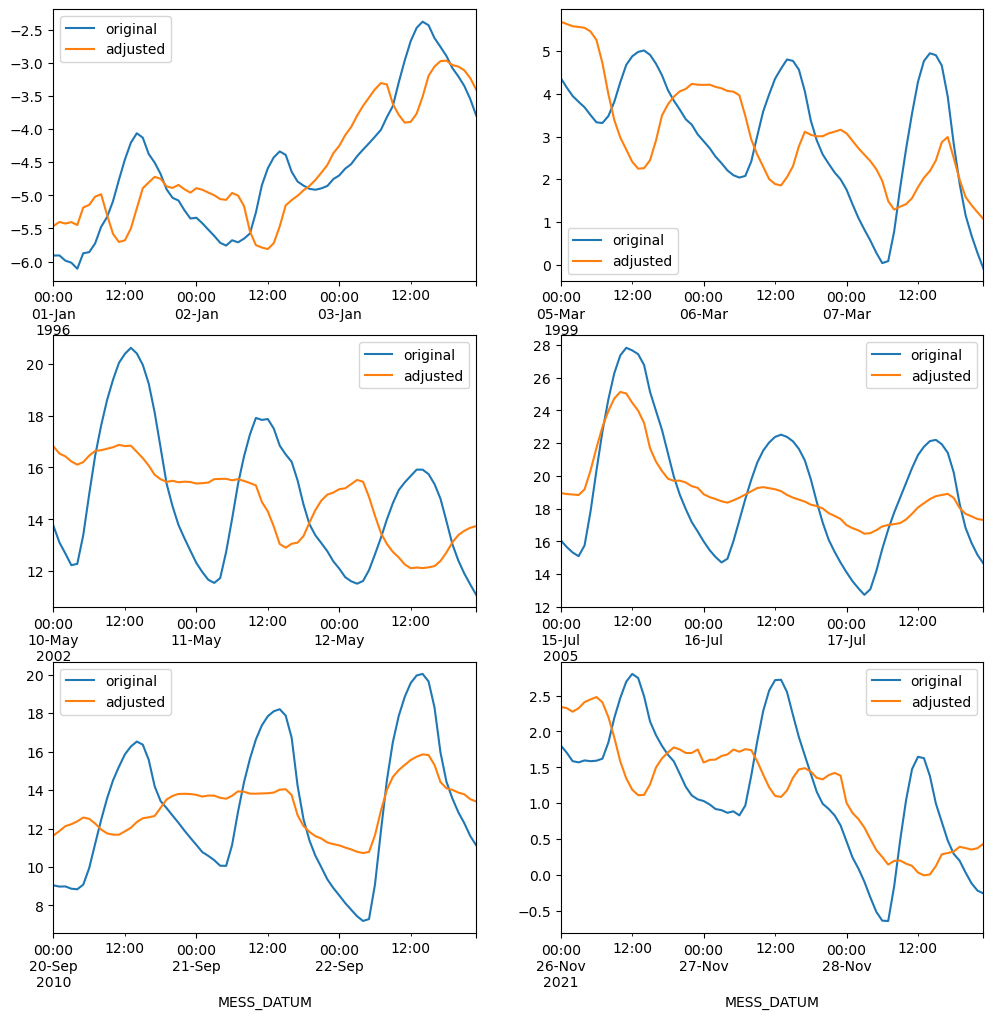

In [32]:
# Let's plot some examples for the temperatures with "removed" daily pattern.
# In the plots below, we can see that the curve has been smoothed.
# As we smooth by mean values, we sometimes under- and sometimes oversmooth.
# But the spread is definitely reduced.

years = ["1996", "1999", "2002", "2005", "2010", "2021"]
months = "01", "03", "05", "07", "09", "11"
start_days  = "01", "05", "10", "15", "20", "26"
end_days  = "03", "07", "12", "17", "22", "28"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    start = "-".join((years[i], months[i], start_days[i]))
    end   = "-".join((years[i], months[i], end_days[i]))

    target_df["temperature"].loc[start : end].plot(ax=ax, label="original")
    target_df["temperature_without_daily_fluctuation"].loc[start : end].plot(ax=ax, label="adjusted")
    ax.legend();

# Extract and subtract the yearly pattern
We want a clean curve as yearly pattern. Methods like STL deliver somehow erratic curves. Therefore we extract the curve as follows:
* resample to daily mean
* detrend by lowess curve
* groupby 'day of year'
* smooth the resulting curve with lowess


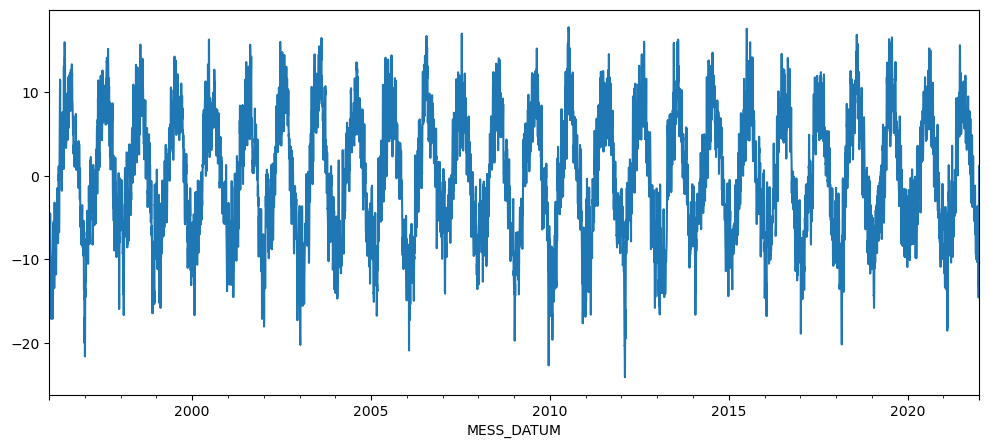

In [33]:
# Detrend the data.

target_df_daily = target_df.resample("1D").mean()

y = target_df_daily["temperature_without_daily_fluctuation"]
x = np.arange(0, len(y))

lowess_res = lowess(
    endog=y,
    exog=x,
    frac=0.25,
    it=3,
)

target_df_daily["trend"] = lowess_res[:, 1]

target_df_daily["temperature_without_daily_fluctuation_detrended"] = \
        target_df_daily["temperature_without_daily_fluctuation"] - target_df_daily["trend"]
target_df_daily["temperature_without_daily_fluctuation_detrended"].plot(figsize=(12, 5));

In [34]:
# Group by 'day of year'

day_of_year = target_df_daily.index.day_of_year

yearly_pattern = target_df_daily.groupby(day_of_year).mean()
yearly_pattern

,temperature,daily_fluctuation,temperature_without_daily_fluctuation,trend,temperature_without_daily_fluctuation_detrended
MESS_DATUM,,,,,
1,0.444774,8.540177e-17,0.444774,9.084254,-8.639480
2,0.388112,1.665335e-16,0.388112,9.084632,-8.696520
3,0.248061,2.505119e-16,0.248061,9.085007,-8.836946
4,0.317047,3.700743e-16,0.317047,9.085380,-8.768332
5,0.067893,3.245267e-16,0.067893,9.085750,-9.017857
...,...,...,...,...,...
362,1.118850,-3.444538e-16,1.118850,9.191617,-8.072767
363,0.274529,-2.661689e-16,0.274529,9.191913,-8.917384
364,0.552062,-1.579933e-16,0.552062,9.192206,-8.640145


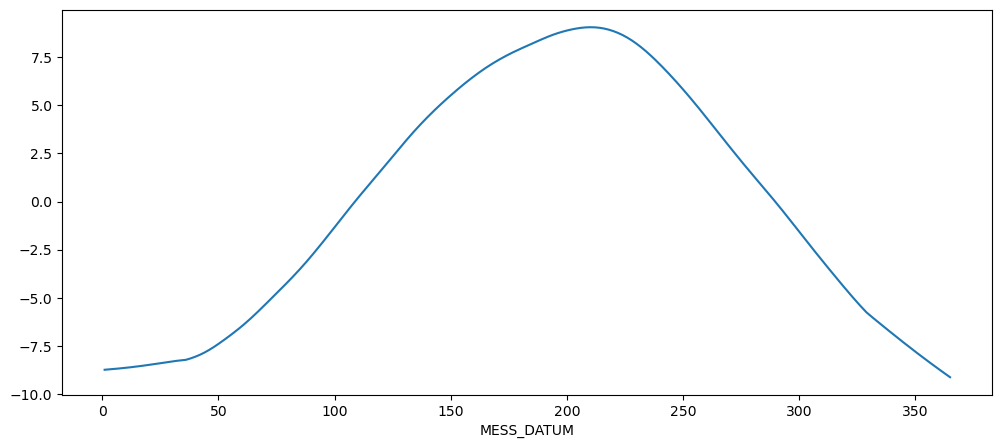

In [35]:
# Smooth by lowess.

y = yearly_pattern["temperature_without_daily_fluctuation_detrended"]
x = np.arange(0, len(y))

lowess_res = lowess(
    endog=y,
    exog=x,
    frac=0.2,
    it=3,
)

yearly_pattern["yearly_fluctuation"] = pd.Series(lowess_res[:, 1]);
yearly_pattern["yearly_fluctuation"].plot(figsize=(12,5));

In [36]:
# Prepare the two dataframes for merging.

target_df["day_of_year"] = target_df.index.day_of_year
yearly_pattern.reset_index(inplace=True)
yearly_pattern.columns = ['day_of_year', 'temperature', 'daily_fluctuation',
                          'temperature_without_daily_fluctuation', 'trend',
                          'temperature_without_daily_fluctuation_detrended',
                          'yearly_fluctuation']
yearly_pattern.drop(["temperature",
                     "daily_fluctuation",
                     "temperature_without_daily_fluctuation",
                     "temperature_without_daily_fluctuation_detrended",
                     "trend"], axis=1, inplace=True)

In [37]:
# Merge and clean.

merged = pd.merge(target_df, yearly_pattern, 
                  left_on="day_of_year", 
                  right_on="day_of_year", 
                  how="left")
merged.index = target_df.index
merged.drop("day_of_year", axis=1, inplace=True)
target_df.drop("day_of_year", axis=1, inplace=True)

In [38]:
# Add trend component.

trend = pd.concat([target_df_daily["trend"]]*24)
trend.sort_index(inplace=True)
trend.index = merged.index
merged["trend"] = trend
del(trend)

In [39]:
# Calculate values without yearly fluctuation and trend.

merged["temperature_without_daily_and_yearly_fluctuation"] = \
    merged["temperature_without_daily_fluctuation"] - merged["yearly_fluctuation"]
merged["residuals"] = merged["temperature_without_daily_and_yearly_fluctuation"] - merged["trend"]
target_df = merged
del(merged)

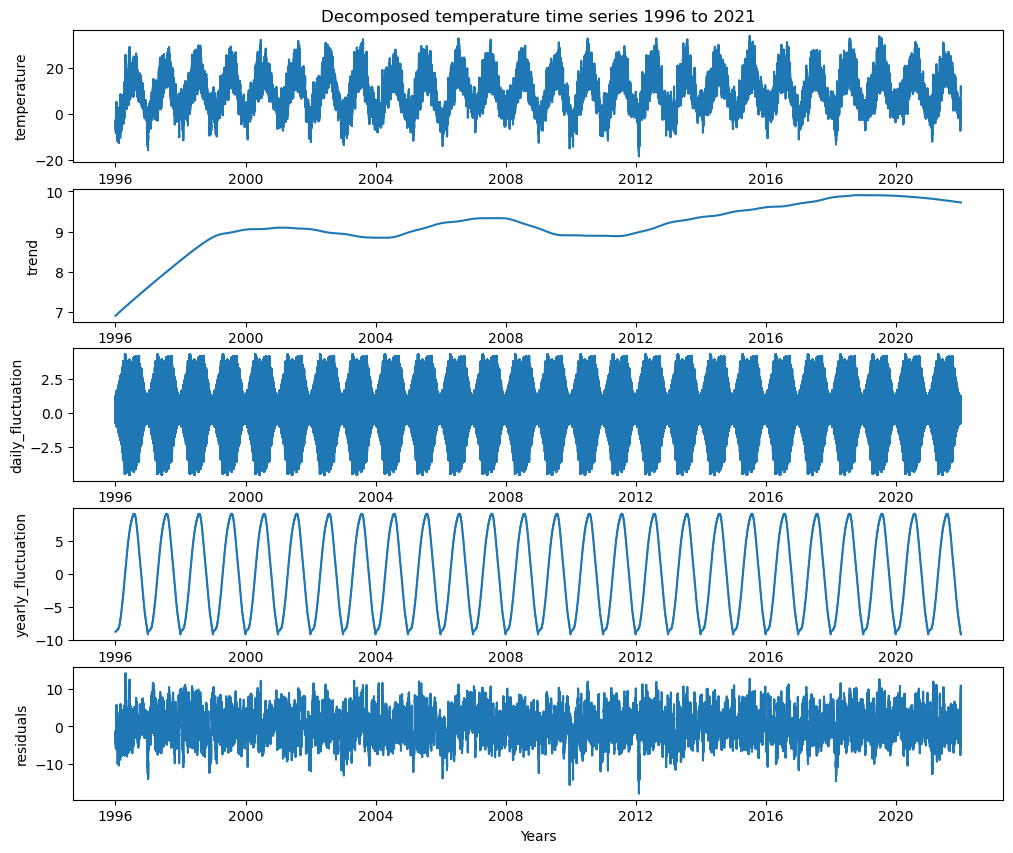

In [40]:
fig, axes = plt.subplots(nrows=5, figsize=(12,10))

sns.lineplot(ax=axes[0], data=target_df, x="MESS_DATUM", y="temperature")
sns.lineplot(ax=axes[1], data=target_df, x="MESS_DATUM", y="trend")
sns.lineplot(ax=axes[2], data=target_df, x="MESS_DATUM", y="daily_fluctuation")
sns.lineplot(ax=axes[3], data=target_df, x="MESS_DATUM", y="yearly_fluctuation")
sns.lineplot(ax=axes[4], data=target_df, x="MESS_DATUM", y="residuals")
axes[0].set_title("Decomposed temperature time series 1996 to 2021")
plt.xlabel("Years");

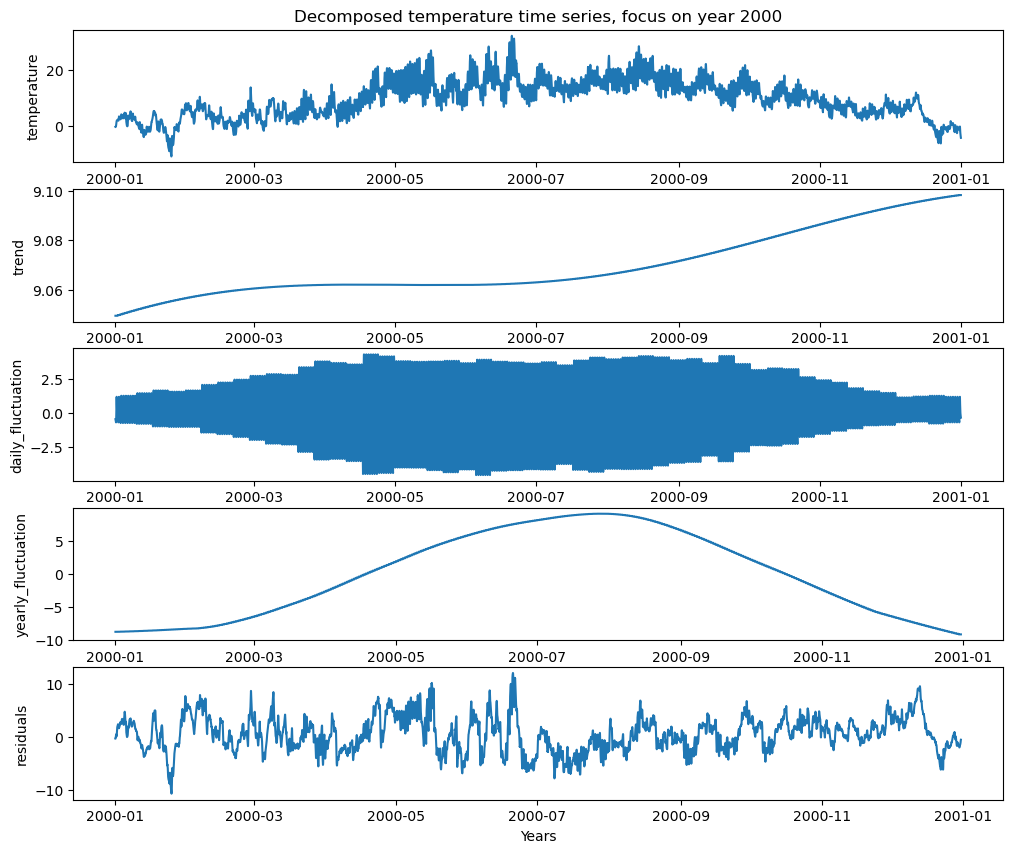

In [41]:
fig, axes = plt.subplots(nrows=5, figsize=(12, 10))

sns.lineplot(ax=axes[0], data=target_df.loc["2000"], x="MESS_DATUM", y="temperature")
sns.lineplot(ax=axes[1], data=target_df.loc["2000"], x="MESS_DATUM", y="trend")
sns.lineplot(ax=axes[2], data=target_df.loc["2000"], x="MESS_DATUM", y="daily_fluctuation")
sns.lineplot(ax=axes[3], data=target_df.loc["2000"], x="MESS_DATUM", y="yearly_fluctuation")
sns.lineplot(ax=axes[4], data=target_df.loc["2000"], x="MESS_DATUM", y="residuals")
axes[0].set_title("Decomposed temperature time series, focus on year 2000")
plt.xlabel("Years");


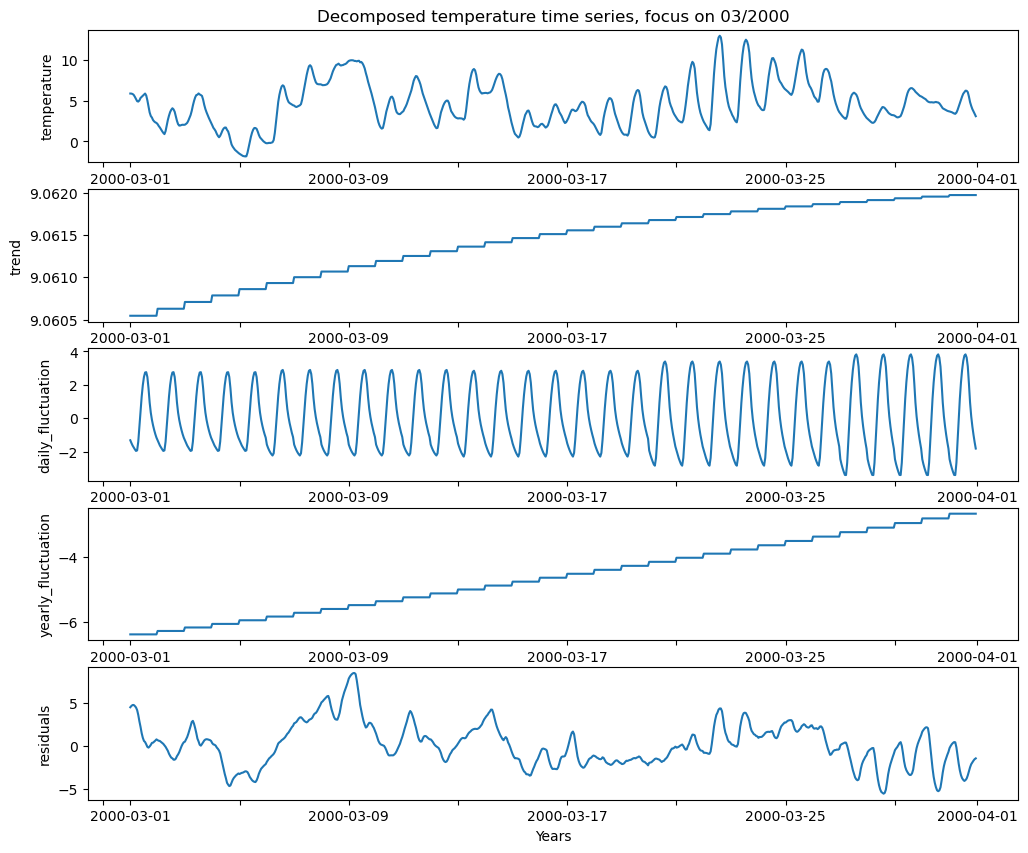

In [42]:
fig, axes = plt.subplots(nrows=5, figsize=(12, 10))

sns.lineplot(ax=axes[0], data=target_df.loc["2000-03"], x="MESS_DATUM", y="temperature")
sns.lineplot(ax=axes[1], data=target_df.loc["2000-03"], x="MESS_DATUM", y="trend")
sns.lineplot(ax=axes[2], data=target_df.loc["2000-03"], x="MESS_DATUM", y="daily_fluctuation")
sns.lineplot(ax=axes[3], data=target_df.loc["2000-03"], x="MESS_DATUM", y="yearly_fluctuation")
sns.lineplot(ax=axes[4], data=target_df.loc["2000-03"], x="MESS_DATUM", y="residuals")
axes[0].set_title("Decomposed temperature time series, focus on 03/2000")
plt.xlabel("Years")
for i in range(0, 5):
    for label in axes[i].xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

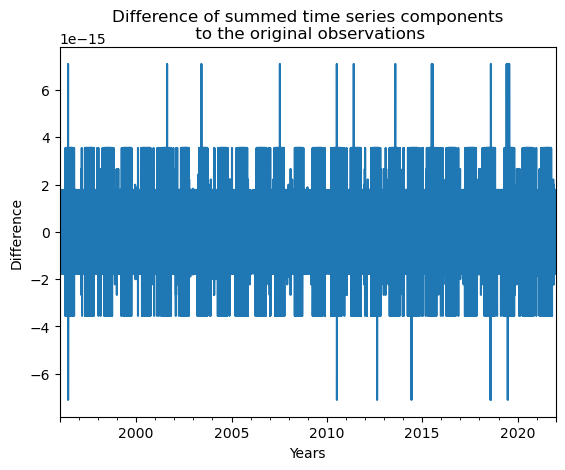

In [43]:
# Sanitiy check. The difference of the summed components to the original time series
# is in the order of magnitude of rounding errors.

sum = target_df["trend"] + target_df["daily_fluctuation"] + target_df["yearly_fluctuation"] + target_df["residuals"]
difference = target_df["temperature"] - sum
difference.plot()
plt.title("Difference of summed time series components\n to the original observations")
plt.ylabel("Difference")
plt.xlabel("Years");